# Lab 6
## Data Structures & Algorithms
### Thursday, 14 March 2024

## Today
* [Continuation: organise code in Flask app](#organising)
* [Continuation: Flask databases with user input](#databases)
* [Big-O refresher](#bigo)
* [Big-O examples](#examples)
* [Exercises](#exercises)

## Organising code in Flask app <a class="anchor" id="organising"></a>

So far, we had all our apps organised as modules (`.py` files). This is fine for small apps with not very much code. As soon as it gets more complex (with databases, forms, etc) it makes sense to change our structure to be a Python package. Read this helpful explanation in [here](https://exploreflask.com/en/latest/organizing.html) for more info on how to organise code in Flask apps. We will update our structure as follows. Instead of this folder structure we've been working with so far

```
my_flask_app
    flaskapp.py
    static/           # contains css files, images etc
    templates/        # contains HTML template files
    instance/         # contains database file
```

we will create a package directory (which requires the `__init__.py` package initialisation file) and move our code into this folder, while refactoring it. Refactoring in this case means moving most of the code from the main app module into `.py` files within the new package directory. Take a look at the updated code in the [github repository](https://github.com/lenafm/my_flask_app) I shared with you last week, which is now in package format.

```
my_flask_app
    flaskapp/
        __init__.py
        static/       # contains css files, images etc
        templates/    # contains HTML template files
            
        routes.py     # code with functions that will be triggered when users visit certain routes (e.g. `/home`)
        models.py     # code for classes that define database tables (=models) (e.g. `BlogPost` class)
        forms.py      # we will see what this is in today's lab
    instance/
        site.db
        config.py
    tests/            # you could have tests in here
    run.py            # this used to be the main flask module - but we move most of its content into the files in the package directory

```

## Flask database with user input <a class="anchor" id="databases"></a>

Last week we learned how to create a database with Flask, add rows to it, and display the data from it in our app. To 'feed' the database with input from users, you can use an HTML form, similar to what we learned in lab 3 and to the homework. 

There is an even easier way to use forms in Flask, through an extension library called `Flask-WTF`, which is a wrapper for the Python library `WTForms` library (like `Flask-SQLAlchemy` is a wrapper for the Python library `SQLAlchemy`). [Here](https://exploreflask.com/en/latest/forms.html) is an introduction on how to use the `Flask-WTF` package.

We will go through the steps required to create and use a Flask form and insert the data from user input into a database - there won't be any exercises on this, it's meant as a resource. I have updated the [github repository](https://github.com/lenafm/my_flask_app) that we used in the last lab to reflect these changes. You can use the repo as a resource for future work/your project etc, or for a more detailed explanation, [part 8](https://www.youtube.com/watch?v=u0oDDZrDz9U&list=PL-osiE80TeTs4UjLw5MM6OjgkjFeUxCYH&index=8) of the Flask youtube tutorial is very helpful. The next five steps require that you have already set up your flask app code in form of a Python package, as shown above.

**Step 1**

Install it into the virtual environment you use for flask development: activate the environment, then run `pip install Flask-WTF`

**Step 2**
In a new `forms.py` file (see folder structure above), include the following code. Note that an alternative here would be to use the `request.form` method you used in the homework for the calculator app. If you did that, you wouldn't need the `forms.py` file and your template (see step 3) would look more similar to the template you created for the calculator app.

```python
from flask_wtf import FlaskForm
from wtforms import StringField, TextAreaField, SubmitField
from wtforms.validators import DataRequired


class PostForm(FlaskForm):
    title = StringField('Title', validators=[DataRequired()]) # field for the title of the post
    content = TextAreaField('Content', validators=[DataRequired()]) # field for the content of the post
    submit = SubmitField('Post')  # submit button to submit to our route
```

**Step 3**
Of course we need to create an HTML template for the form which a user will use to add a blog post, let's call it `create_post.html`; in its simplest form, it could look like this:

```html
{% extends "layout.html" %}
{% block content %}
    <h1>{{ title }}</h1>
    <form method="post" action="">
            {{ form.hidden_tag() }}
        <div>
            {{ form.title.label() }}<br>
            {{ form.title }}
        </div>
        <div>
            {{ form.content.label() }}<br>
            {{ form.content() }}
        </div>
        <div>
            {{ form.submit() }}
        </div>
    </form>
{% endblock %}
```

**Step 4**
With our new package format, the `PostForm` class and `create_post.html` template we have created, we can then define our new route in the `routes.py` file:

```python
from flask import render_template, flash, redirect, url_for
from flaskapp import app, db
from flaskapp.models import BlogPost
from flaskapp.forms import PostForm


# Route for the home page, which is where the blog posts will be shown
@app.route("/")
@app.route("/home")
def home():
    # Querying all blog posts from the database
    posts = BlogPost.query.all()
    return render_template('home.html', posts=posts)


# Route for the about page
@app.route("/about")
def about():
    return render_template('about.html', title='About page')


# Route to where users add posts (needs to accept get and post requests)
@app.route("/post/new", methods=['GET', 'POST'])
def new_post():
    form = PostForm() 
    if form.validate_on_submit():
        post = BlogPost(title=form.title.data, content=form.content.data, user_id=1)
        db.session.add(post)
        db.session.commit()
        flash('Your post has been created!', 'success')
        return redirect(url_for('home'))
    return render_template('create_post.html', title='New Post', form=form)
```

**Step 5**
Finally, we need to update our `layout.html` template, so that it includes a link to the New Post page:

```html
<!DOCTYPE html>
<html>
<head>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no">
    <link rel="stylesheet" type="text/css" href="{{ url_for('static', filename='main.css') }}">
</head>
<body>
<header>
    <div id="container">
        <h1 class="logo">My web app</h1>
        <strong>
            <nav>
                <ul class="menu">
                    <li><a href="{{ url_for('home') }}">Home</a></li>
                    <li><a href="{{ url_for('about') }}">About</a></li>
                    <li><a href="{{ url_for('new_post') }}">New post</a></li>
                </ul>
            </nav>
        </strong>
    </div>
</header>
<div class="container">
    {% block content %}
    {% endblock %}
</div>
</body>
</html>
```

## Big-O refresher <a class="anchor" id="bigo"></a>

You have already seen this a couple of times in lectures, but here is yet another Big-O notation reminder; it's taken from a really helpful [Big-O Cheatsheet](https://www.bigocheatsheet.com/), where you can also find some tables with the time and space complexity for some common algorithms.

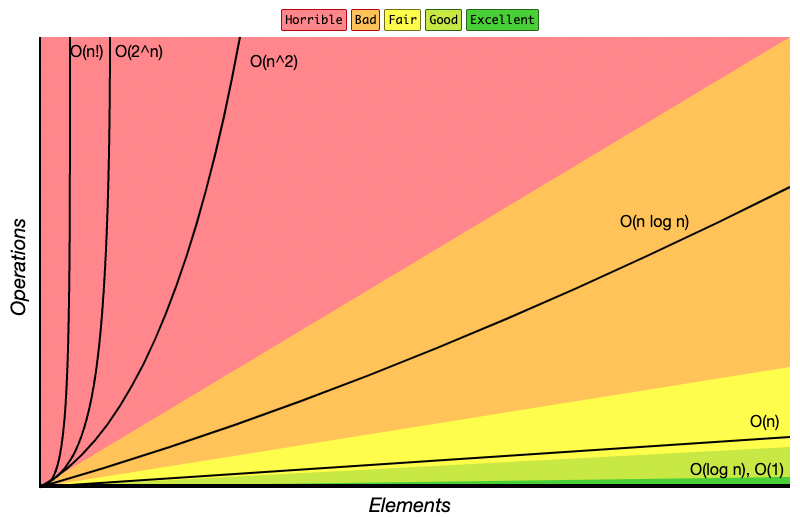

A different way of putting this is by looking at the actual running time of algorithms that have different time complexity (borrowed from the textbook Algorithm Design by Kleinberg & Tardos):

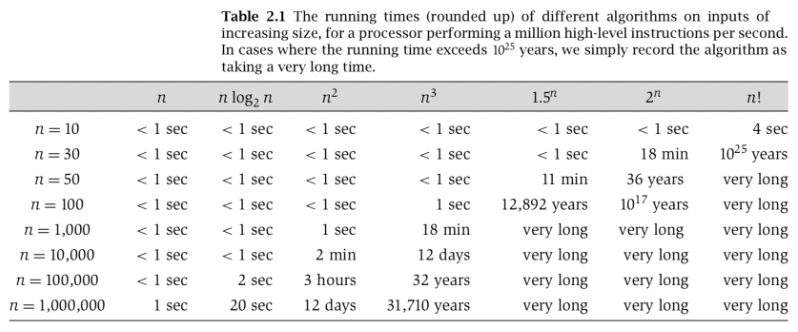

## Examples

## Example 1

Let us write a function to check whether the parentheses in the input string are valid, meaning that they are always in pairs and in correct order. We want to implement this using a stack and with

* time complexity `O(n)`
* space complexity  `O(n)`

For this example, we'll use **stacks**. Remember that stacks are structures in which data is stored in LIFO (last in first out) fashion. Accordingly, the two major operations one can do with a stack is to push (an element onto the stack) or to pop (the top element off the stack). 

**Why use stacks (or queues)?**
They help you keep track of your data in a different way, since there is no random data access with stacks (and queues). This means that data is less adaptable and also less easily corruptible. 

Because they assist you in managing your data in a more specific manner than arrays and lists. It means you won’t have to wonder if someone placed an element in the midst of your list at random, messing up certain invariants when troubleshooting an issue.Random access is the nature of arrays and lists. They’re incredibly adaptable, but they’re also easily corruptible. If you wish to keep track of your data,It’s recommended to use those, previously implemented, collections when storing data as FIFO or LIFO. In short, use stacks (or queues) instead of arrays/lists when

* we want to have elements in specific order (order in which they were put in (queue) or reverse order (stack)
* we require dynamic memory (arrays are static)
* sequential access is needed
* we want to efficiently remove data from end (stack) or start (queue) of data structure

In Python, we can use lists as stacks as follows:

In [1]:
# Initialize a stack
stack = [1]

# Push 2 into the stack
stack.append(2)
print(stack)

# Pop the top off the stack
print(stack.pop())
print(stack)

[1, 2]
2
[1]


In [2]:
def check_parentheses(s):
    """
    Check whether the parentheses in the input string are valid
    The parentheses are valid if they are always in pairs and in correct order 
    You may assume the string only includes '(' and ')'
    
    Parameters
    ----------
    s : a string
    
    Returns
    ----------
    True or False : boolean
    """

    stack = []

    for c in s:
        if c == ')':
            # If the parentheses are not in pairs or in correct order
            if (len(stack) == 0) or ('(' != stack.pop()):
                return False
        else:
            # Push '('
            stack.append(c)

    return True if len(stack) == 0 else False

In [3]:
s_1 = "()"
s_2 = ")("
s_3 = "()()"
s_4 = "(())"

print(check_parentheses(s_1))
print(check_parentheses(s_2))
print(check_parentheses(s_3))
print(check_parentheses(s_4))

True
False
True
True


## Example 2

In the lecture, you heard about algorithms to find a target value in an array. Let's see how it can be implemented in python, first in the 'naive' way and then using binary search.

Find a target without binary search (in `O(n)`):

In [4]:
def find_target(arr, target):
    """
    Find a target in an array
    You can assume the items in the array are unique
    
    Parameters
    ----------
    arr : a list of integers
    target : an integer
    
    Returns
    ----------
    The index of the target, if the target is in the array
    None, otherwise
    """

    # Loop over each element in the array
    for i in range(len(arr)):
        if arr[i] == target:
            return i
            
    return None

Now let's implement binary search:

In [5]:
def binary_search(arr, target):
    """
    The binary search algorithm
    
    Parameters
    ----------
    arr : a list of integers
    target : an integer
    
    Returns
    ----------
    The index of the target, if the target is in the array
    None, otherwise
    """
    
    # The starting and ending point of the input array
    left, right = 0, len(arr) - 1
    
    # While the subarray is not empty
    while (left <= right):
        # Get the index of the middle item in the subarray
        mid = left + (right - left) // 2
        
        # If the middle item equals the target
        if arr[mid] == target:
            return mid
        # If the middle item is larger than the target
        elif arr[mid] > target:
            right = mid - 1
        # If the middle item is smaller than the target
        else:
            left = mid + 1
            
    return None

In [6]:
# Test
arr_1 = [2]
arr_2 = [3]
arr_3 = [2, 3]

print(binary_search(arr_1, 3))
print(binary_search(arr_2, 3))
print(binary_search(arr_3, 3))

None
0
1


This has time complexity `O(log(n))` because:

* the search space is reduced by half at each step!
* at the first step, we are searching an array of size n, at the second step it's of size n/2, then n/4, etc.
* at step k, the length of the array is $\frac{n}{2^k}$
* assume after k iterations we've halved our arrray so many times that the size is 1 (and we've reached our target)
* so we can set $\frac{n}{2^k}=1$, therefore $k=log_2(n)$ and time complexity is `O(log(n))`.

## Exercises <a class="anchor" id="exercises"></a>

### Exercise 1

Improve the code in Example 1, to have space complexity `O(1)`. Hint: Try to implement it without using stacks.

In [7]:
def check_parentheses1(s):
    """
    Check whether the parentheses in the input string are valid
    The parentheses are valid if they are always in pairs and in correct order 
    You may assume the string only includes '(' and ')'
    
    Parameters
    ----------
    s : a string
    
    Returns
    ----------
    True or False : boolean
    """

    # Implement me
    count = 0

    for c in s:
        if c == ')':
            count -= 1            
        else:
            count += 1
        # If the parentheses are not in correct order
        if count < 0:
            return False
    
    # If the parentheses are in pairs, return True; Otherwise, return False
    return True if count == 0 else False

In [8]:
s_1 = "()"
s_2 = ")("
s_3 = "()()"
s_4 = "(())"

print(check_parentheses1(s_1))
print(check_parentheses1(s_2))
print(check_parentheses1(s_3))
print(check_parentheses1(s_4))

True
False
True
True


### Exercise 2

Improve the code in Example 1, so that it now also allows square and curly brackets, with time complexity `O(n)`. Hint: For this one, do use stacks again - similarly to Example 1. 

In [9]:
def check_parentheses2(s):
    """
    Check whether the parentheses in the input string are valid
    The parentheses are valid if they are always in pairs and in correct order 
    You may assume the string includes not only '(' and ')', but also '[' and ']' and '{' and '}'   
    
    Parameters
    ----------
    s : a string
    
    Returns
    ----------
    True or False : boolean
    """

    # Implement me
    lefts, rights = ['(', '[', '{'], [')', ']', '}']
    stack = []

    for c in s:
        if c in rights:
            idx = rights.index(c)
            # If the parentheses are not in pairs or in correct order
            if (len(stack) == 0) or (lefts[idx] != stack.pop()):
                return False
        else:
            stack.append(c)

    return True if len(stack) == 0 else False

In [10]:
s_1 = "()"
s_2 = ")("
s_3 = "()()"
s_4 = "{([])}"

print(check_parentheses2(s_1))
print(check_parentheses2(s_2))
print(check_parentheses2(s_3))
print(check_parentheses2(s_4))

True
False
True
True


### Exercise 3

Improve your solution from Exercise 2, by using a dictionary! Hint: The time complexity will remain the same, but the total number of operations should be smaller.

In [11]:
def check_parentheses3(s):
    """
    Check whether the parentheses in the input string are valid
    The parentheses are valid if they are always in pairs and in correct order 
    You may assume the string includes not only '(' and ')', but also '[' and ']' and '{' and '}'   
    
    Parameters
    ----------
    s : a string
    
    Returns
    ----------
    True or False : boolean
    """

    # Implement me
    parentheses = {')': '(', '}': '{', ']': '['}
    stack = []

    for c in s:
        if c in parentheses.keys():
            if (len(stack) == 0) or (parentheses[c] != stack.pop()):
                return False
        else:
            stack.append(c)

    return True if len(stack) == 0 else False

In [12]:
s_1 = "()"
s_2 = ")("
s_3 = "()()"
s_4 = "{([])}"

print(check_parentheses3(s_1))
print(check_parentheses3(s_2))
print(check_parentheses3(s_3))
print(check_parentheses3(s_4))

True
False
True
True


### Exercise 4

In the lecture, you learnt about the Sieve of Eratosthenes, an algorithm to find all prime numbers up to a specified integer. To remind you, it works based on the folloing idea: For a given input integer n, the algorithm works by iteratively marking the multiples of primes as composite, starting from 2. Once all multiples of 2 have been marked composite, the muliples of next prime, ie 3 are marked composite. This process continues until $p \leq \sqrt n$ where $p$ is a prime number. For this exercise, implement this algorithm.

In [13]:
def sieve_of_eratosthenes(n):
    """
    Implement the Sieve of Eratosthenes algorithm to find all prime numbers up to a given integer n.

    Parameters:
    n (int): An integer greater than 1.

    Returns:
    list: A list containing all prime numbers up to n.

    Example:
    >>> sieve_of_eratosthenes(10)
    [2, 3, 5, 7]
    """
    
    # Create a list with n+1 elements and initialize all entries as true
    prime = [True for _ in range(n+1)]
    p = 2
    while p**2 <= n:
        # If prime[p] has not been marked False, then p is a prime
        if prime[p]:
            # Update all multiples of p that are greater than p**2
            for i in range(p**2, n+1, p):
                prime[i] = False
        p += 1
    
    # Create list with all prime numbers up to n by appending the values for which prime[i] is true
    primes = []
    for i in range(2, n+1):
        if prime[i]:
            primes.append(i)
    return primes

In [14]:
n = 30
print("Prime numbers up to", n, "are:", sieve_of_eratosthenes(n))

Prime numbers up to 30 are: [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]


### Exercise 5

Using the function we saw in Example 2 for binary search, extend the binary search algorithm as follows: unlike the `binary_search` function above (which returns None when the target is not in the input array) here we want to return the index where the target should be inserted (so that the array is still sorted in ascending order).

In [15]:
def binary_search_idx(arr, target):
    """
    Find a target in an array
    You can assume the items in the array are unique
    
    Parameters
    ----------
    arr : a list of integers
    target : an integer
    
    Returns
    ----------
    The index of the target, if the target is in the array
    The index where the target should be inserted (so that the array is still sorted in ascending order), otherwise
    """
    
    # Implement me
    # The starting and ending point of the input array
    left, right = 0, len(arr) - 1
    
    # While the subarray is not empty
    while (left <= right):
        # Get the index of the middle item in the subarray
        mid = left + (right - left) // 2
        
        # If the middle item equals the target
        if arr[mid] == target:
            return mid
        # If the middle item is larger than the target
        elif arr[mid] > target:
            right = mid - 1
        # If the middle item is smaller than the target
        else:
            left = mid + 1
            
    return left

In [16]:
arr_1 = [2]
arr_2 = [4]
arr_3 = [2, 3, 4]

print(binary_search_idx(arr_1, 3))
print(binary_search_idx(arr_2, 3))
print(binary_search_idx(arr_3, 3))

1
0
1
